# Pre-requisites

The below will install the python dependencies and download the kaggle dataset. Note that kaggle.json (API key) will need to be downloaded from your kaggle account and placed at ~/.kaggle/kaggle.json.

In [57]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
%pip install keras
%pip install tensorflow
%pip install kaggle
%pip install seaborn
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [58]:
import os
import kaggle
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Embedding, Dense
from keras.optimizers import Adam
import nltk
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.stem import WordNetLemmatizer
import string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/lewiscooper/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lewiscooper/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [59]:
# get home directory for user
home = os.path.expanduser("~")
# check if the file ~/.kaggle/kaggle.json exists using os.path
if not os.path.exists(home + "/.kaggle/kaggle.json"):
    raise RuntimeError("Kaggle API key missing")

# if dataset does not exist, download it
if not os.path.exists("train.csv") and not os.path.exists("test.csv"):
    print("Downloading dataset")
    kaggle.api.authenticate()
    kaggle.api.competition_download_files("nlp-getting-started")
    !unzip nlp-getting-started.zip

# Introduction

The Kaggle link to the challenge can be found here: https://www.kaggle.com/competitions/nlp-getting-started/overview

The dataset contains:

- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)


In [60]:
train_df = pd.read_csv("train.csv")
train_df.head()

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

----- Null counts -----
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

----- Null counts -----
id        0
text      0
target    0
dtype: int64


# EDA

Looking at the features we can see that many rows of data are missing for the features keyword and location. They may provide useful information but for simplicity we will drop them.

In [ ]:
print("\n----- Null counts -----")
null_counts = train_df.isna().sum()
print(null_counts)

# drop keyword and location columns
train_df.drop(columns=["keyword", "location"], inplace=True)
print("\n----- Null counts -----")
null_counts = train_df.isna().sum()
print(null_counts)


We can observe the number of entries for each label. A skewed distribution could affect our performance later.

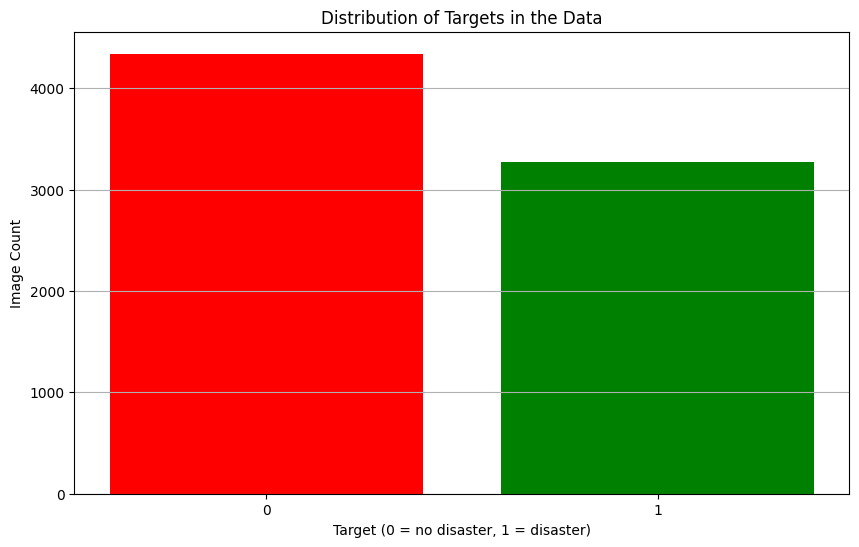

In [61]:
labels, counts = zip(*Counter(train_df["target"]).items())
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color=["green", "red"])
plt.xlabel("Target (0 = no disaster, 1 = disaster)")
plt.ylabel("Image Count")
plt.title("Distribution of Targets in the Data")
plt.xticks(labels)
plt.grid(axis='y')
plt.show()

Many words in the tweets are probably stop words or filler words with no content. We can observe this be showing the most common words in all the tweets.

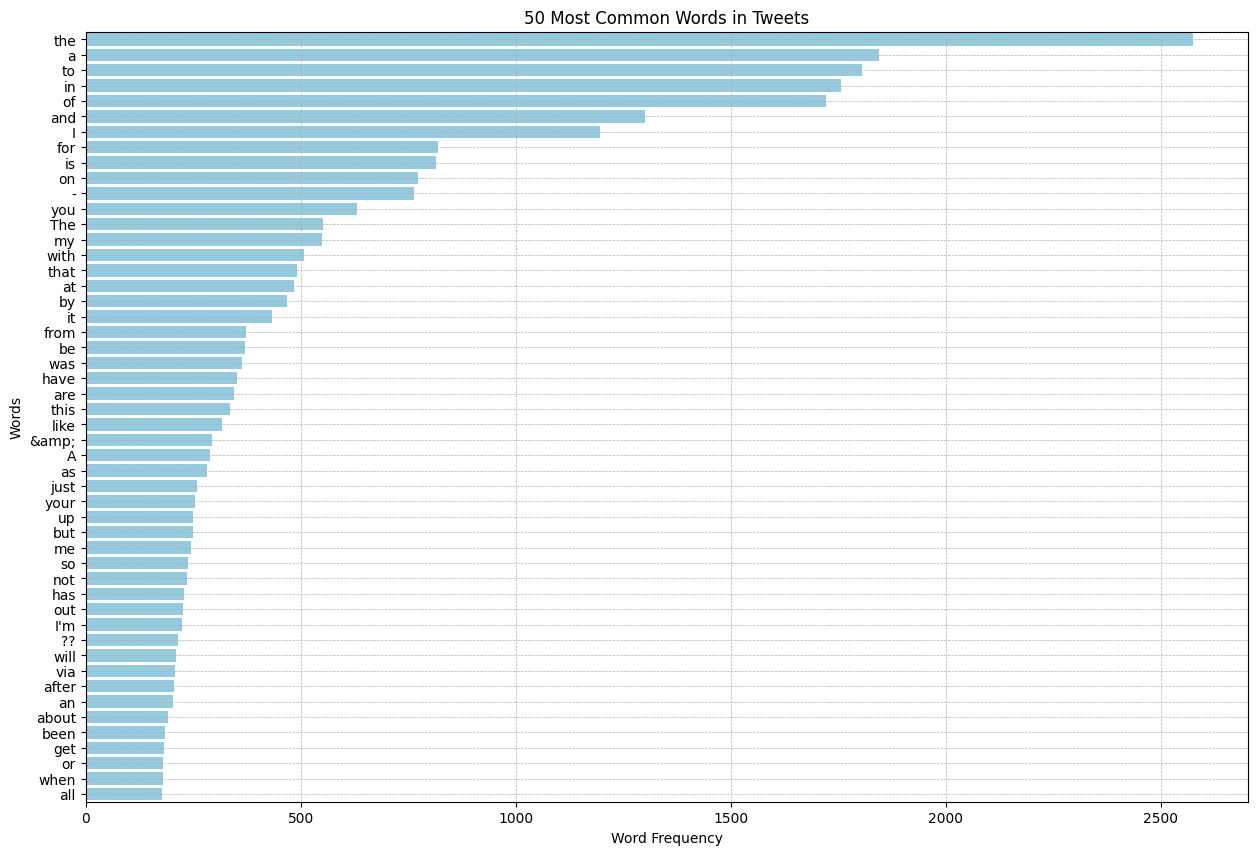

In [62]:
most_common_word_count = 50
words = [word for text in train_df['text'] for word in text.split()]
word_frequencies = Counter(words)
common_words, common_counts = zip(*word_frequencies.most_common(most_common_word_count))

plt.figure(figsize=(15, 10))
sns.barplot(x=list(common_counts), y=list(common_words), color='skyblue')
plt.title(f'{most_common_word_count} Most Common Words in Tweets')
plt.xlabel('Word Frequency')
plt.ylabel('Words')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


### Text Pre-processing

Regardless of model type text preprocessing is a fundamental step in natural language processing (NLP). Raw text data is inherently noisy and unstructured, so preprocessing helps to transform it into a more digestible form for machine learning models. We will perform the following.

**Tokenization**

This breaks down the text into individual words or tokens because learning model don't understand text and continous sentences but as individual token. Each word should be treated as a separate entity.

**Removing Stop Words**

We have already applied this in our word frequency analysis but significance is words like (e.g., "and", "the", "is") don't carry significant meaning on their own. Removing them reduces the dimensionality of the data and can help the model focus on more meaningful words.

**Stemming/Lemmatization**

Stemming reduces words to their base or root form (e.g., "running" -> "run") while Lemmatization transforms words to their base form based on dictionary meaning (e.g., "better" -> "good"). This reduces the vocabulary size and groups particular words to the same word improving model generalization.

**Lowercasing**

This convert all characters to a lower case and ensures we don't have duplicate words like "Hello", "hello" and "HELLO". 

**Removing Punctuation and Special Characters**

Stripping the text of punctuation marks and other non-alphanumeric characters can help reduce noise in the data.

**Vectorization**

This essentially convert text data in a numerical format to be used on a machine learning model. Common methods include Count Vectorization (as seen earlier in our text frequency graphs), TF-IDF (Term Frequency-Inverse Document Frequency), and word embeddings. It would be benficial to have cleaned dataframe ready for each of these methods.

In [63]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Tokenization (splitting the text into words)
    tokens = text.split()
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

train_df["clean_text"] = train_df['text'].apply(preprocess_text)

From here we tokenize our cleaned text data into integers.

- Tokenization: This involves converting the text into a sequence of integers, where each integer represents a unique word in the text. We use a tokenizer to build a word index, mapping words to integers.
- Padding Sequences: RNN models require input sequences of the same length. We'll pad shorter sequences with zeros to ensure all sequences have the same length.
- Splitting Data: We'll also need to split the data into training and testing sets to train and evaluate the LSTM model.

In addition our tokenizer needs to know the max number of words we want to have in our vocabularly. Since since stop words have been removed from our dataset we'll programmatically detect our vocabulary size.

In [64]:
def calculate_vocab_size(text):
    unique_words = set()
    for sentence in text:
        unique_words.update(sentence.split())
    return len(unique_words)

num_unique_words = calculate_vocab_size(train_df['clean_text'])
num_unique_words

21272

In [65]:
def tokenize_data(text, max_words):
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    max_sequence_length = max(len(x) for x in sequences)
    data_padded = pad_sequences(sequences, maxlen=max_sequence_length)
    return data_padded

data_padded = tokenize_data(train_df['clean_text'], num_unique_words)

X_train, X_test, y_train, y_test = train_test_split(data_padded, train_df['target'], test_size=0.2, random_state=42)

# Model Architecture

Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) architecture designed to address the vanishing gradient problem encountered by traditional RNNs. LSTM networks are particularly effective for sequential data tasks, such as natural language processing and time series analysis. The key benefit of LSTM lies in its ability to mitigate two critical issues: gradient explosion and gradient vanishing.

In terms of gradient explosion, LSTM employs a gating mechanism that regulates the flow of information through the network during training. This gating mechanism consists of three gates: the input gate, forget gate, and output gate. These gates control which information to keep, forget, or pass through the network, making it less prone to gradients becoming excessively large and causing instability during training.

On the other hand, LSTM also addresses the problem of gradient vanishing. By maintaining an internal cell state that can carry information over long sequences, LSTM allows gradients to flow through the network more effectively, preventing them from becoming overly small when dealing with sequences that are temporally distant. This makes it well-suited for tasks where capturing long-range dependencies is crucial.

Some of the hyperparameters compared in various models are:

- output_dim: This hyperparameter determines the dimensionality of the word embeddings in the Embedding layer. Different values of output_dim affect the richness and complexity of the learned word representations.

- lstm_units: This hyperparameter controls the number of LSTM units in the LSTM layer. Modifying lstm_units changes the capacity of the LSTM layer to capture patterns and dependencies in sequential data.

- dropout_rate: Dropout is a regularization technique used to prevent overfitting. The dropout_rate hyperparameter specifies the dropout rate applied to both the input and recurrent connections of the LSTM layer. Adjusting this rate changes the amount of regularization applied to the model.

- learning_rate: Learning rate is a critical hyperparameter for the optimization process. It determines the step size during weight updates in training. Different values of learning_rate can affect the convergence speed and stability of training.

In [69]:
def create_lstm_model(learning_rate, input_dim, output_dim, lstm_units, dropout_rate):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim))
    model.add(LSTM(units=lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate))

    # Add a Dense layer with 1 unit for binary classification
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])

    return model

def plot_history(history):
    # Summarize history for accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title("Accuracy")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title("Loss")
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# static parameters
epochs = 10
batch_size = 32
input_dim = num_unique_words

# hyperparameters
output_dim =   [32,     32,     128,     128,   32,     32,     128,     128]
lstm_units =   [32,     32,     128,     128,   32,     32,     128,     128]
dropout_rate = [0,      0,      0,       0,     0.5,    0.5,    0.5,     0.5]
learning_rate= [0.001,  0.01,  0.001,   0.01, 0.001,    0.01,  0.001,   0.01]

models = []
for i in range(len(output_dim)):
    models.append(create_lstm_model(learning_rate[i], input_dim, output_dim[i], lstm_units[i], dropout_rate[i]))

histories = []
for model in models:
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    histories.append(history)


Epoch 1/10
191/191 [==============================] - 5s 15ms/step - loss: 0.5720 - accuracy: 0.6923 - val_loss: 0.4378 - val_accuracy: 0.8070
Epoch 2/10
191/191 [==============================] - 2s 12ms/step - loss: 0.2921 - accuracy: 0.8846 - val_loss: 0.4758 - val_accuracy: 0.8024
Epoch 3/10
191/191 [==============================] - 2s 12ms/step - loss: 0.1404 - accuracy: 0.9476 - val_loss: 0.5909 - val_accuracy: 0.7636
Epoch 4/10
191/191 [==============================] - 2s 12ms/step - loss: 0.0719 - accuracy: 0.9755 - val_loss: 0.6336 - val_accuracy: 0.7597
Epoch 5/10
191/191 [==============================] - 2s 12ms/step - loss: 0.0378 - accuracy: 0.9888 - val_loss: 0.9211 - val_accuracy: 0.7341
Epoch 6/10
191/191 [==============================] - 2s 12ms/step - loss: 0.0299 - accuracy: 0.9920 - val_loss: 0.7760 - val_accuracy: 0.7498
Epoch 7/10
191/191 [==============================] - 2s 12ms/step - loss: 0.0221 - accuracy: 0.9946 - val_loss: 0.9420 - val_accuracy: 0.7525

# Results and Analysis

In evaluating the performance of the LSTM models with varying hyperparameters, it becomes evident that many of these models exhibit symptoms of overfitting as the number of training epochs increases. Overfitting occurs when a model becomes overly specialized in learning the training data to the detriment of its ability to generalize to unseen data. This phenomenon is observed as a divergence between the training and validation performance.

Specifically, as the number of training epochs progresses, the models tend to achieve increasingly higher accuracy on the training data, accompanied by a reduction in training loss. However, a contrasting trend emerges when examining the validation data. The accuracy on the validation set often reaches an optimal point and then starts to decline, while the validation loss begins to rise. This divergence signifies that the models are becoming overly tailored to the training data's noise and may struggle to generalize effectively to new, unseen data.

Model 1 with 0.001 learning rate, 32 output dim, 32 LSTM units, and 0 dropout rate


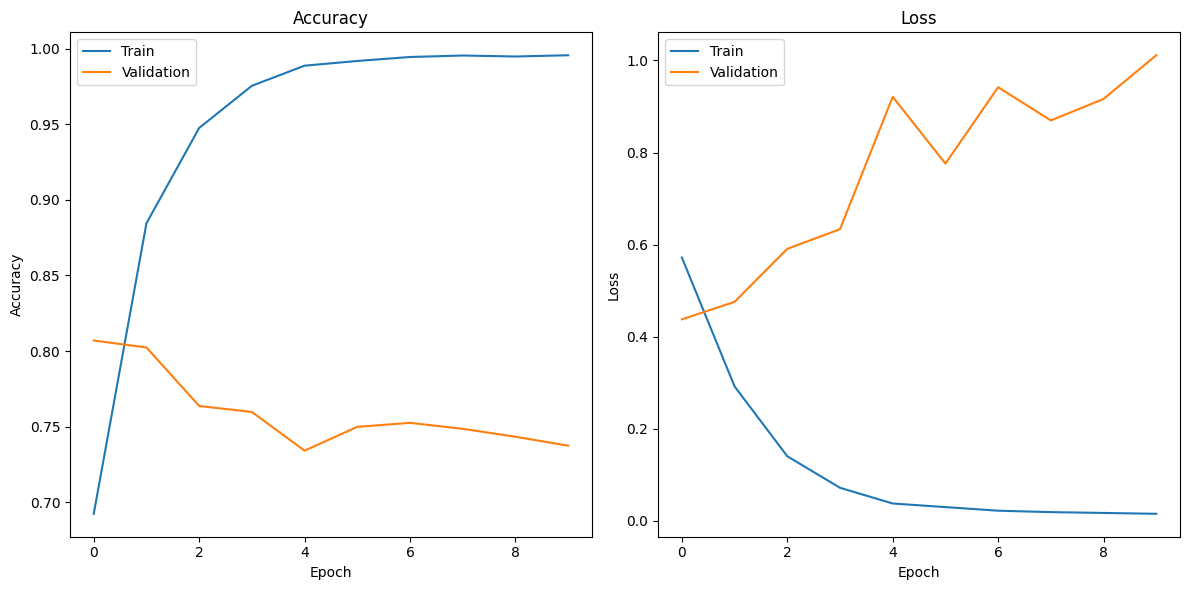

Model 2 with 0.01 learning rate, 32 output dim, 32 LSTM units, and 0 dropout rate


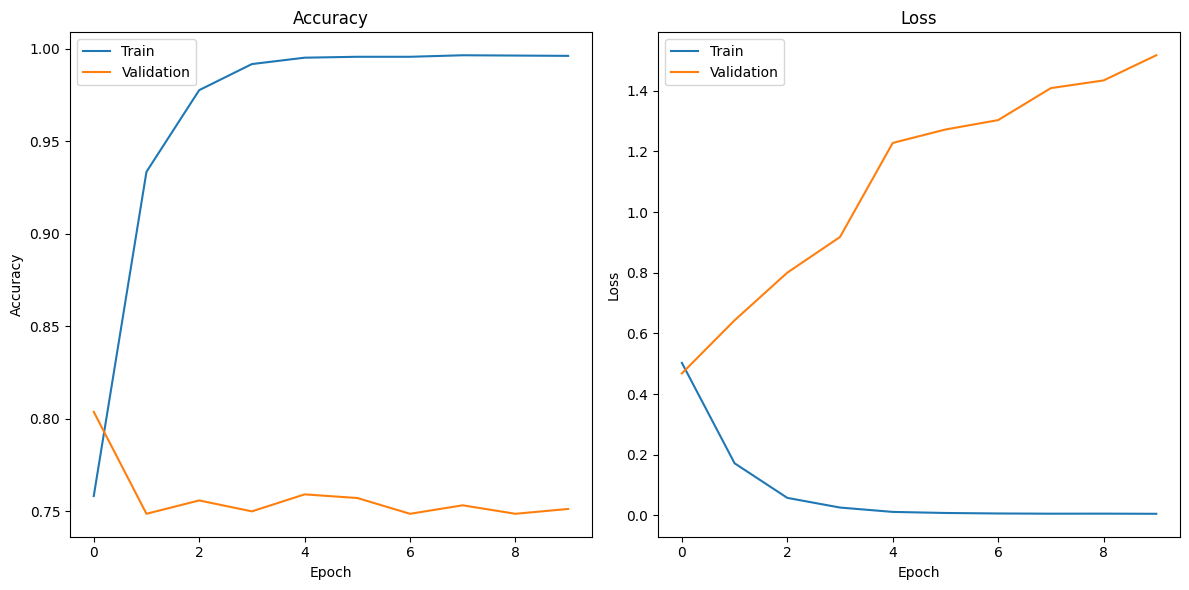

Model 3 with 0.001 learning rate, 128 output dim, 128 LSTM units, and 0 dropout rate


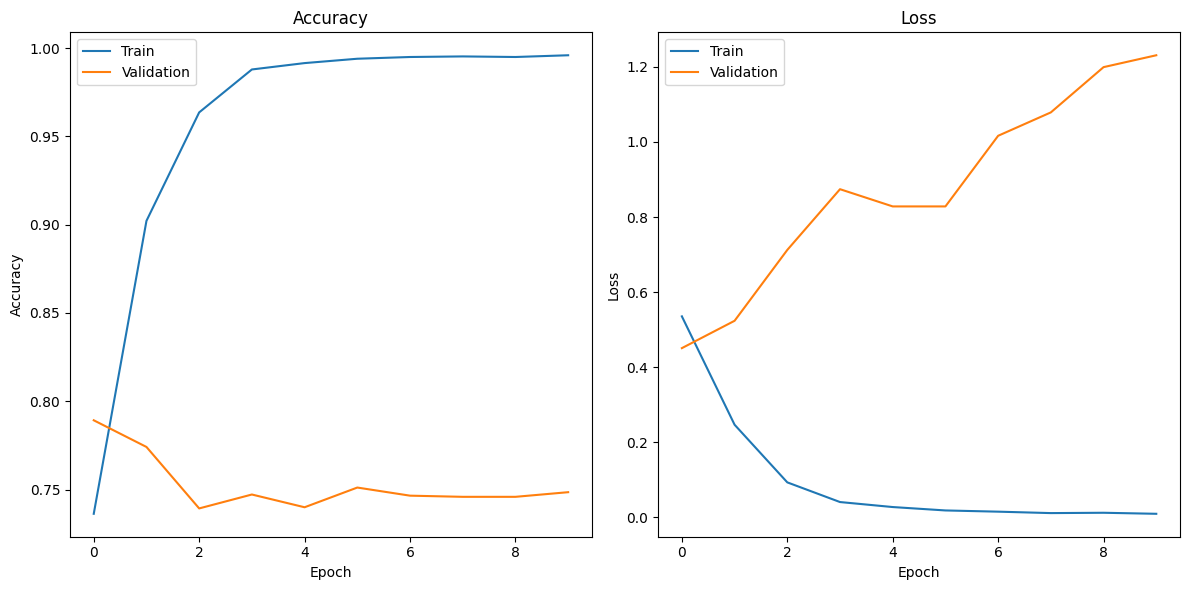

Model 4 with 0.01 learning rate, 128 output dim, 128 LSTM units, and 0 dropout rate


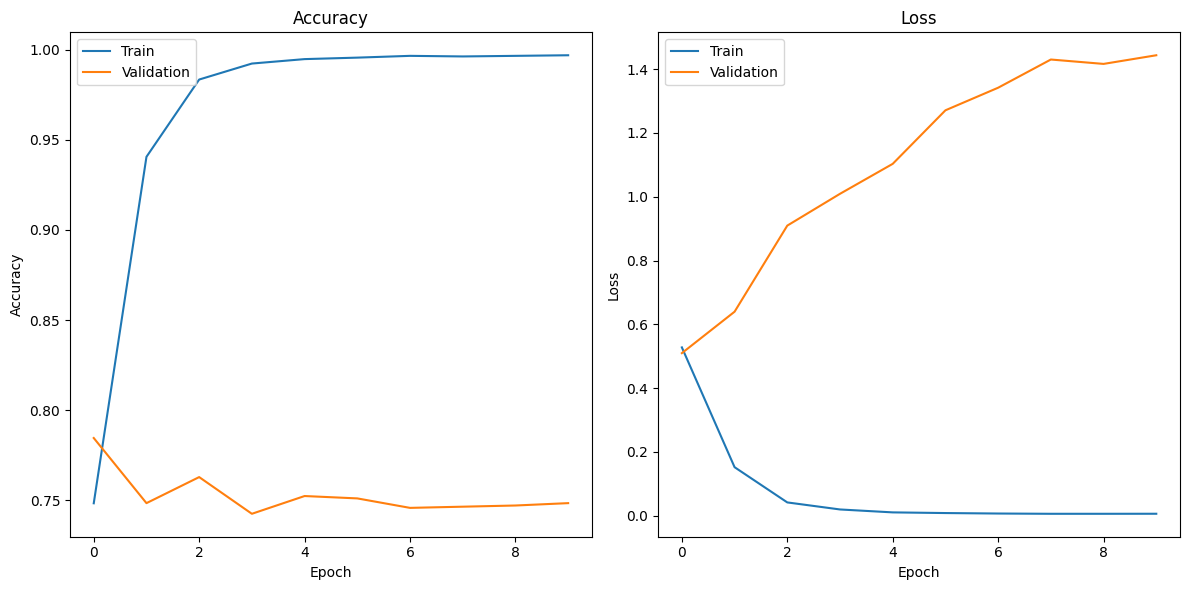

Model 5 with 0.001 learning rate, 32 output dim, 32 LSTM units, and 0.5 dropout rate


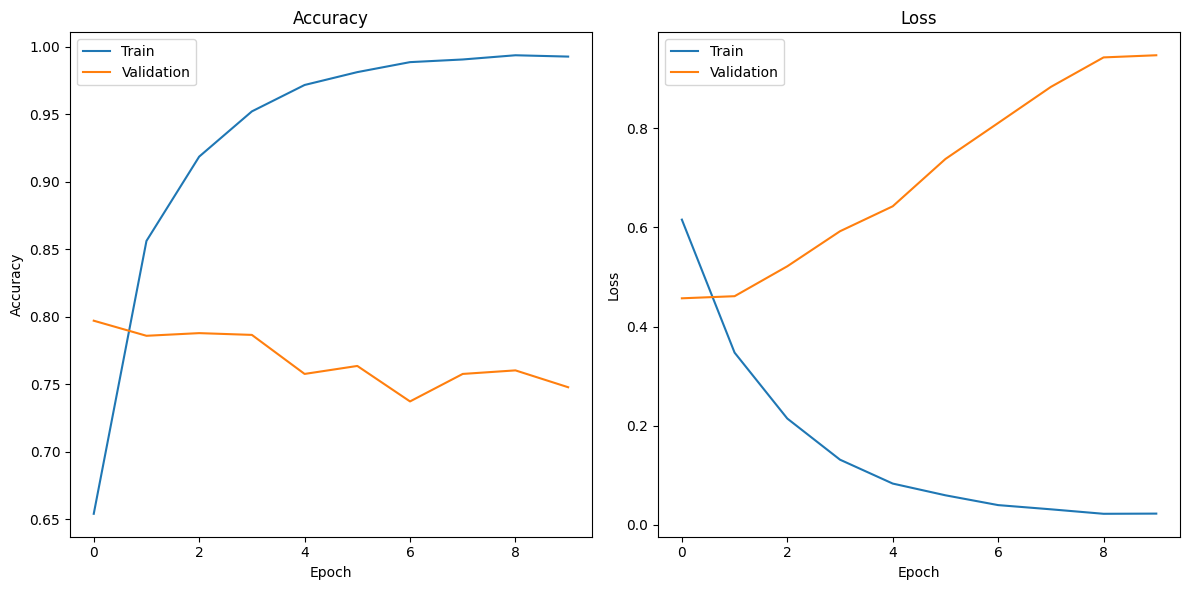

Model 6 with 0.01 learning rate, 32 output dim, 32 LSTM units, and 0.5 dropout rate


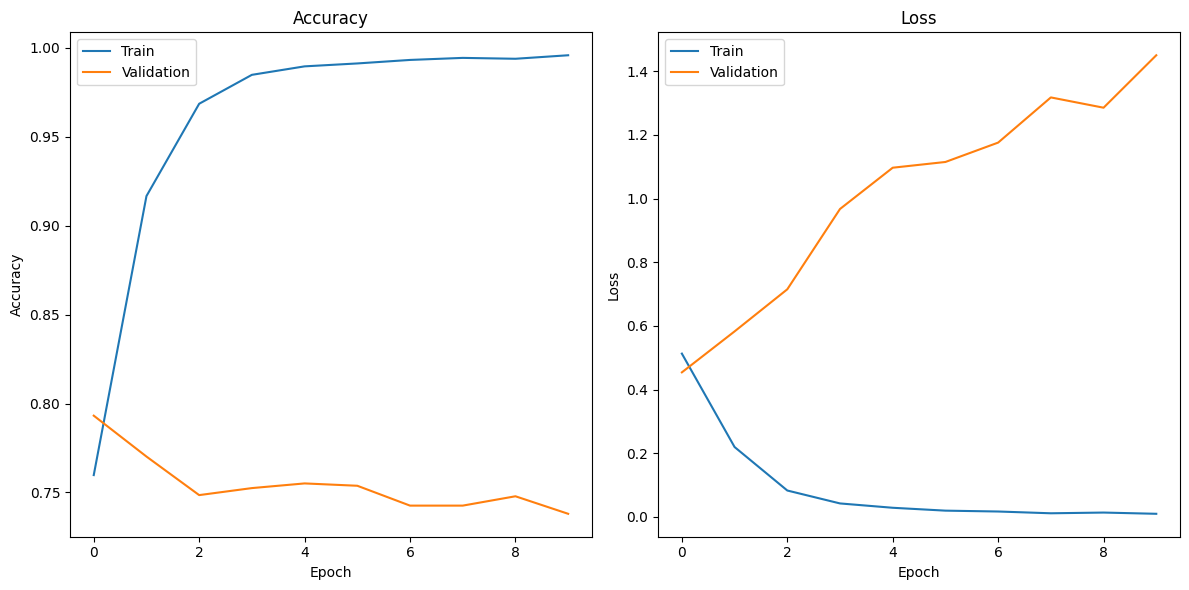

Model 7 with 0.001 learning rate, 128 output dim, 128 LSTM units, and 0.5 dropout rate


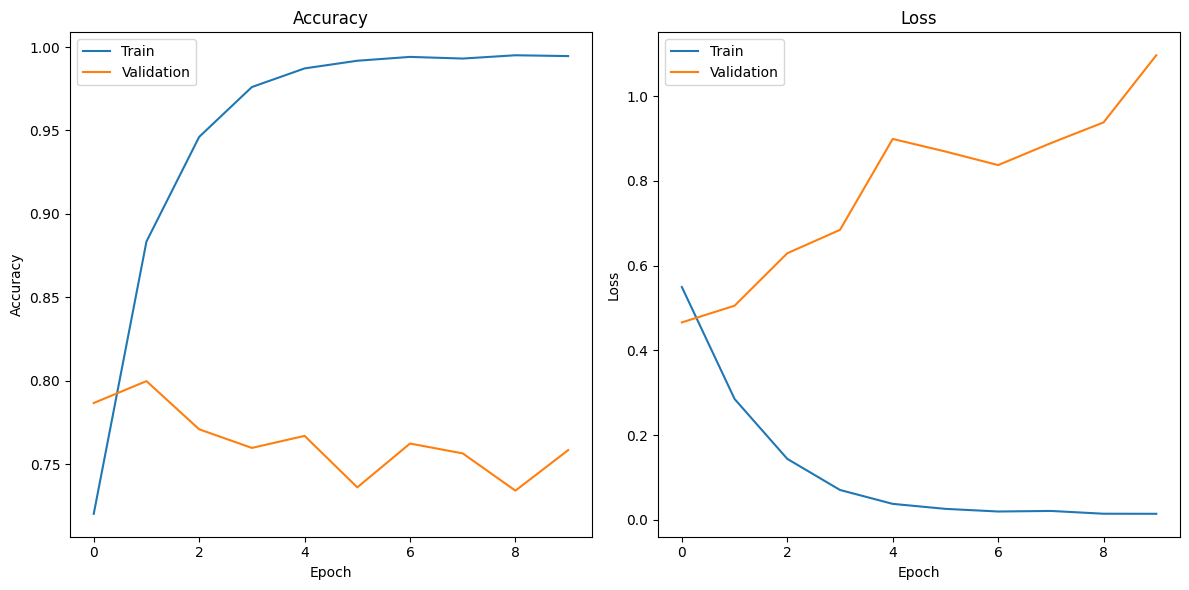

Model 8 with 0.01 learning rate, 128 output dim, 128 LSTM units, and 0.5 dropout rate


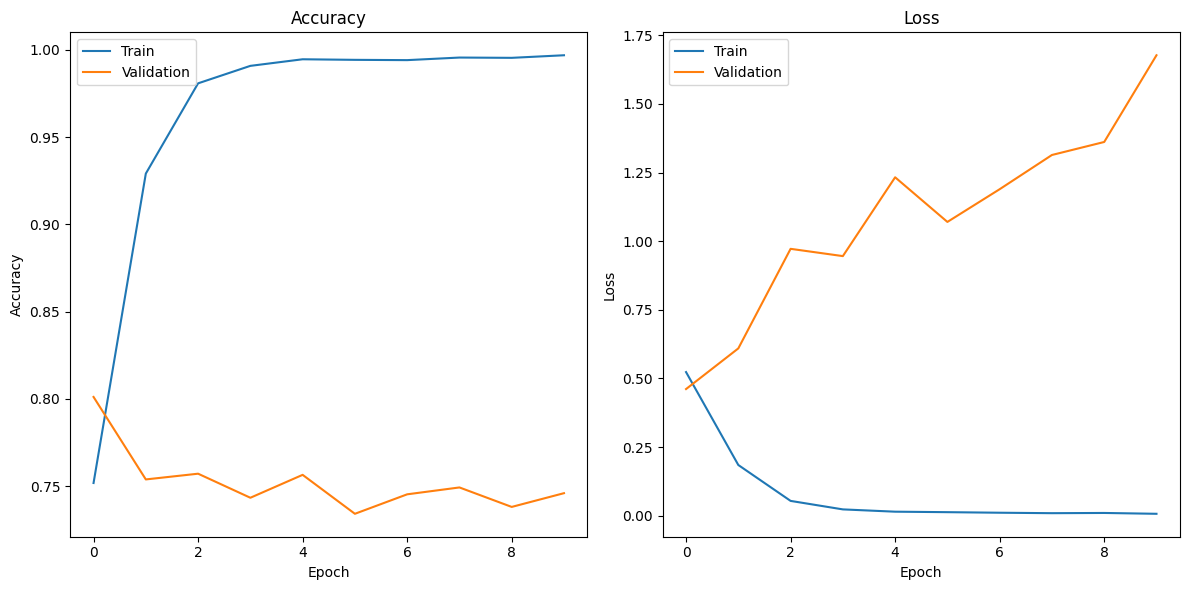

In [70]:
for i in range(len(histories)):
    info = f"Model {i+1} with {learning_rate[i]} learning rate, {output_dim[i]} output dim, {lstm_units[i]} LSTM units, and {dropout_rate[i]} dropout rate"
    print(info)
    plot_history(histories[i])

# Conclusion

The results obtained from the experimentation with different LSTM model configurations provide valuable insights into the model's behavior, primarily highlighting the challenge of overfitting. Overfitting, as evidenced by the decreasing validation accuracy and increasing validation loss as the number of training epochs progresses, indicates that the models are becoming excessively specialized in learning the nuances of the training data at the expense of their ability to generalize to unseen data.

To improve the performance of these models and mitigate the issue of overfitting, several strategies can be considered:

- Early Stopping: Implement an early stopping mechanism that monitors the validation loss and terminates training when it starts to increase consistently. This prevents the models from overfitting and ensures that they are saved at an optimal point.

- Regularization: Increase the use of dropout regularization within the LSTM layers. Higher dropout rates can help reduce overfitting by randomly dropping out connections during training, thereby preventing the model from relying too heavily on specific training examples.

- Hyperparameter Tuning: Continue experimenting with a broader range of hyperparameters, including different learning rates, LSTM unit sizes, and embedding dimensions. Hyperparameter tuning can help identify configurations that strike a better balance between model complexity and generalization.

- More Training Data: If feasible, consider obtaining and incorporating more training data into the model. A larger and more diverse dataset can help the models generalize better.

- Transfer Learning: Investigate the possibility of using pre-trained word embeddings or transfer learning from models trained on related tasks. Transfer learning can provide a head start in capturing relevant features.

In [72]:
def create_submission(model, test_df, filename):
    test_df["clean_text"] = test_df["text"].apply(preprocess_text)
    num_unique_words = calculate_vocab_size(test_df["clean_text"])
    padded_data = tokenize_data(test_df["clean_text"], num_unique_words)
    test_predictions = (model.predict(padded_data) > 0.5).astype("int32")
    output = pd.DataFrame({'id': test_df["id"], 'target': test_predictions.reshape((-1,))})
    output.to_csv(filename, index=False)

def submit_submission(filename):
    kaggle.api.authenticate()
    kaggle.api.competition_submit(filename, "NLP Disaster Tweets", "nlp-getting-started")

best_model = models[4]
filename = "submission.csv"
test_df = pd.read_csv("test.csv")
create_submission(best_model, test_df, filename)

input = input("Submit to Kaggle? (y/n): ")
if input == "y":
    submit_submission(filename)

102/102 [==============================] - 0s 3ms/step


100%|██████████| 22.2k/22.2k [00:01<00:00, 12.4kB/s]
